<img src="header.jpg">

# Fashion Visual Search demo

## 1. Vectors embeddings with Azure Computer Vision 4

Vector embeddings are a way of representing content such as text or images as vectors of real numbers in a high-dimensional space. These embeddings are often learned from large amounts of textual and visual data using machine learning algorithms like neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears. By representing content as vectors, we can perform mathematical operations on them to compare their similarity or use them as inputs to machine learning models.

## Business applications
- Digital asset management: Image retrieval can be used to manage large collections of digital images, such as in museums, archives, or online galleries. Users can search for images based on visual features and retrieve the images that match their criteria.
- Medical image retrieval: Image retrieval can be used in medical imaging to search for images based on their diagnostic features or disease patterns. This can help doctors or researchers to identify similar cases or track disease progression.
- Security and surveillance: Image retrieval can be used in security and surveillance systems to search for images based on specific features or patterns, such as in, people & object tracking, or threat detection.
- Forensic image retrieval: Image retrieval can be used in forensic investigations to search for images based on their visual content or metadata, such as in cases of cyber-crime.
- E-commerce: Image retrieval can be used in online shopping applications to search for similar products based on their features or descriptions or provide recommendations based on previous purchases.
- Fashion and design: Image retrieval can be used in fashion and design to search for images based on their visual features, such as color, pattern, or texture. This can help designers or retailers to identify similar products or trends.

## To learn more
- https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-image-retrieval
- https://learn.microsoft.com/en-us/azure/search/search-what-is-azure-search

> Note: Image retrieval is curently in public preview

In [1]:
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
import sys

from datetime import datetime
from dotenv import load_dotenv
from IPython.display import Image
from PIL import Image as PILImage

In [2]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [3]:
def file_info(file_path):
    """
    File informations
    """
    filename = os.path.basename(file_path)
    size = os.path.getsize(file_path)
    last_modified = datetime.fromtimestamp(os.path.getmtime(file_path)).strftime(
        "%Y-%m-%d %H:%M:%S"
    )

    print(f"Filename: {filename}")
    print(f"Size: {size} bytes")
    print(f"Last modified: {last_modified}")

## 1. Azure Computer Vision 4.0 Florence connection

In [4]:
file_info("azure.env")

Filename: azure.env
Size: 670 bytes
Last modified: 2023-06-22 12:08:45


In [5]:
load_dotenv("azure.env")

acv_key = os.getenv("acv_key")
acv_endpoint = os.getenv("acv_endpoint")

# The azure endpoint should not finished a /
if acv_endpoint.endswith("/"):
    acv_endpoint= acv_endpoint[:-1]

## 2. Functions

In [6]:
def image_url_embedding(imageurl):
    """
    Url image vector embeddings using Azure Computer Vision 4
    """
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_img_url = acv_endpoint + "/computervision/retrieval:vectorizeImage" + version
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    image = {"url": imageurl}
    r = requests.post(vec_img_url, data=json.dumps(image), headers=headers)
    
    if r.status_code == 200:
        image_emb = r.json()["vector"]
        return image_emb
    
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [7]:
def text_embedding(promptxt):
    """
    Text vector embedding text using using Azure Computer Vision 4
    """
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_txt_url = acv_endpoint + "/computervision/retrieval:vectorizeText" + version
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    prompt = {"text": promptxt}
    r = requests.post(vec_txt_url, data=json.dumps(prompt), headers=headers)
    
    if r.status_code == 200:
        text_emb = r.json()["vector"]
        return text_emb
    
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [8]:
def get_cosine_similarity(vector1, vector2):
    """
    Get cosine similarity value between two embedded vectors
    """
    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return round(cosine_similarity, 10)

In [9]:
def similarity_results(image_emb, prompts):
    """ "
    Get similarity results
    """
    simil_values_list = [
        get_cosine_similarity(image_emb, text_embedding(prompt)) for prompt in prompts
    ]
    sorted_results = sorted(
        zip(prompts, simil_values_list), key=lambda x: x[1], reverse=True
    )

    df = pd.DataFrame(columns=["prompt", "cosine_similarity"])

    for idx, (prompt, simil_val) in enumerate(sorted_results):
        df.loc[idx, "prompt"] = prompt
        df.loc[idx, "cosine_similarity"] = simil_val

    df["cosine_similarity"] = df.cosine_similarity.astype(float)

    return df

## 3. Image and prompts

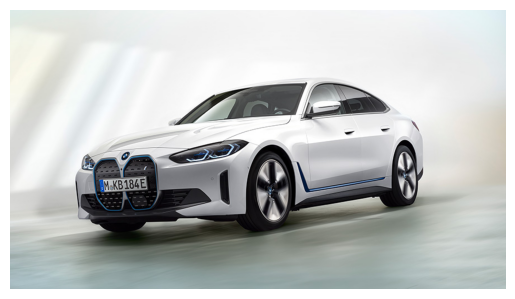

In [10]:
image_url = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [11]:
embeddings = image_url_embedding(image_url)
print("Size of the vector embeddings =", len(embeddings))

Size of the vector embeddings = 1024


In [12]:
text = text_embedding("a cat")

In [13]:
print("Size of the vector embeddings =", len(text))

Size of the vector embeddings = 1024


In [14]:
get_cosine_similarity(embeddings, text)

0.1483671254

In [15]:
text2 = text_embedding("a BMW white car")

In [16]:
get_cosine_similarity(embeddings, text2)

0.3486092834

## 4. Multiple prompts

In [17]:
prompts = [
    "a truck",
    "a car",
    "a white car",
    "a BMW white car",
    "a tesla car",
    "a mercedes car",
    "a man",
    "a ford car",
    "an i4 BMW car",
    "I do not know",
]

In [18]:
df = similarity_results(embeddings, prompts)
cm = sns.light_palette("blue", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [19]:
df.values.tolist()[0]

['an i4 BMW car', 0.3571341666]

### Example 2

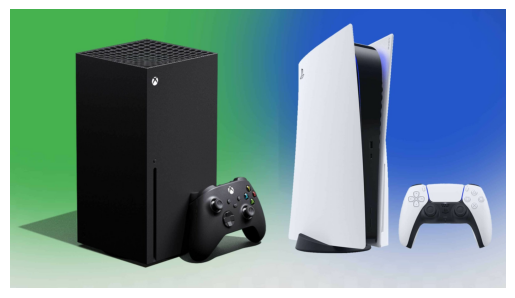

In [20]:
image_url = "https://github.com/retkowsky/images/blob/master/xboxps5.jpg?raw=true"
embeddings = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [21]:
prompts = [
    "PS5",
    "Xbox",
    "play station",
    "Sony",
    "controller",
    "Microsoft",
    "games console",
    "guitar",
    "fish",
    "apple",
    "car",
    "street",
    "truck",
    "Miami",
    "black controller",
    "white controller",
]

In [22]:
df = similarity_results(embeddings, prompts)
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

### Example 3

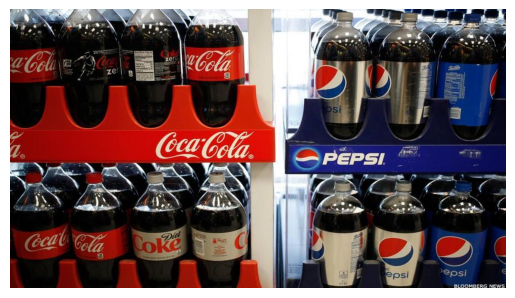

In [23]:
image_url = "https://github.com/retkowsky/images/blob/master/sodas.jpg?raw=true"
embeddings = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [24]:
prompts = [
    "a can",
    "coca cola",
    "pepsi",
    "7 up",
    "water",
    "wine",
    "beer",
    "gin",
    "alcohol",
    "lemon",
    "drink",
    "I do not know",
    "food",
    "soda bottles",
    "coke bottle",
]

In [25]:
df = similarity_results(embeddings, prompts)
cm = sns.light_palette("pink", as_cmap=True)
df.style.background_gradient(cmap=cm)

## 4. Images similarity with vectors embeddings

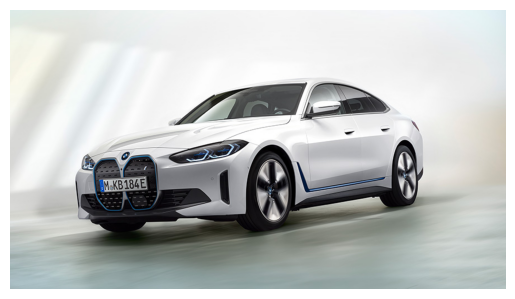

In [26]:
image_url = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"
car = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

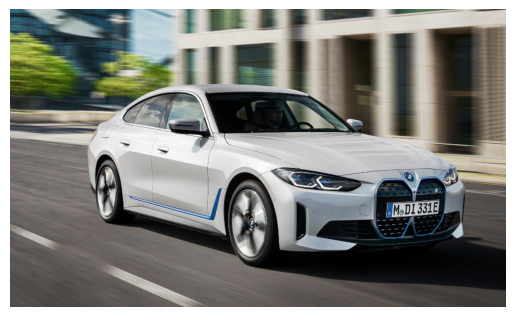

In [27]:
image_url = "https://github.com/retkowsky/images/blob/master/i4_2.jpg?raw=true"
bmwcar = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

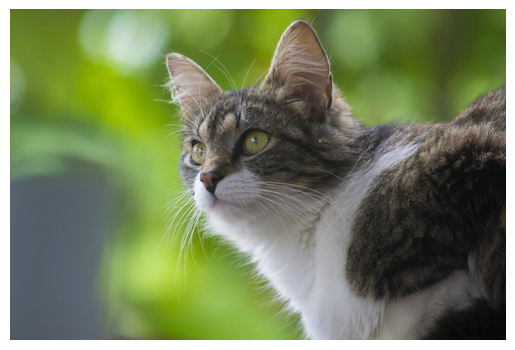

In [28]:
image_url = "https://github.com/retkowsky/images/blob/master/cat.jpg?raw=true"
cat = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [29]:
def image_comparison(cosine):
    """
    Decision
    """
    if round(cosine, 2) == 1:
        print("\033[1;31;34m")
        print("Result: Same image")

    elif cosine >= 0.7:
        print("\033[1;31;32m")
        print("Result: Almost similar image")

    else:
        print("\033[1;31;91m")
        print("Result: Different image")

    print("Cosine similarity =", cosine)

In [30]:
print("Cosine similarity between an image and the same image:")
cosine = get_cosine_similarity(car, car)
image_comparison(cosine)

Cosine similarity between an image and the same image:

Result: Same image
Cosine similarity = 1.0


In [31]:
print("Cosine similarity between the car image and the another car image:")
cosine = get_cosine_similarity(car, bmwcar)
image_comparison(cosine)

Cosine similarity between the car image and the another car image:

Result: Almost similar image
Cosine similarity = 0.9472660876


In [32]:
print("Cosine similarity between the car image and the cat image:")
cosine = get_cosine_similarity(car, cat)
image_comparison(cosine)

Cosine similarity between the car image and the cat image:

Result: Different image
Cosine similarity = 0.3390264066


## 5. An application example

In [33]:
def image_embeddings(local_image):
    """
    Local image embeddigns with Azure Computer Vision
    """
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": acv_key,
    }
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_img_url = acv_endpoint + "/computervision/retrieval:vectorizeImage" + version

    # Reading the images in binary
    with open(local_image, "rb") as f:
        data = f.read()
    # Sending the request
    r = requests.post(vec_img_url, data=data, headers=headers)
    # Get the vector embeddings
    image_emb = r.json()["vector"]

    return image_emb

In [34]:
prompts = [
    "a bird",
    "a car",
    "a red car",
    "a red Tesla car",
    "a blue Tesla car",
    "a green Tesla car",
    "a black Tesla car",
    "a white Tesla car",
    "a purple Tesla car",
    "an orange Tesla car",
    "a gray Tesla car",
    "a Mercedes car",
    "a BMW car",
    "a FIAT car",
    "a Maserati car",
    "a Tesla car",
    "an Alpha-Romeo car",
    "a man",
    "a cat",
    "a Rolls-Royce car",
    "a dog",
]

In [35]:
colors = [
    "black car",
    "white car",
    "yellow car",
    "blue car",
    "green car",
    "purple car",
    "grey car",
    "red car",
    "brown car",
    "pink car",
    "orange car",
]

### Test 1

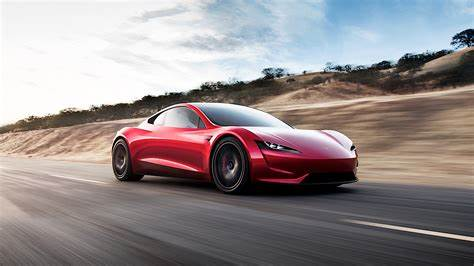

In [36]:
local_image = "car.jpg"

Image(filename=local_image)

In [37]:
image_emb = image_embeddings(local_image)

In [38]:
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [39]:
print("This image is", df.values.tolist()[0][0])

This image is a red Tesla car


In [40]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, colors)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [41]:
print("Color information:", df.values.tolist()[0][0])

Color information: red car


### Test 2

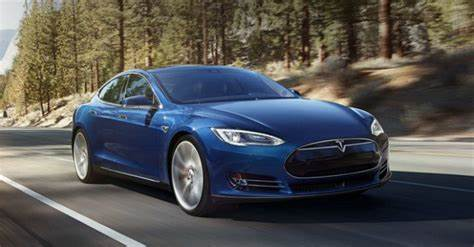

In [42]:
local_image = "car2.jpg"

Image(filename=local_image)

In [43]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [44]:
print("This image is", df.values.tolist()[0][0])

This image is a blue Tesla car


In [45]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, colors)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [46]:
print("Color information:", df.values.tolist()[0][0])

Color information: blue car


### Test 3

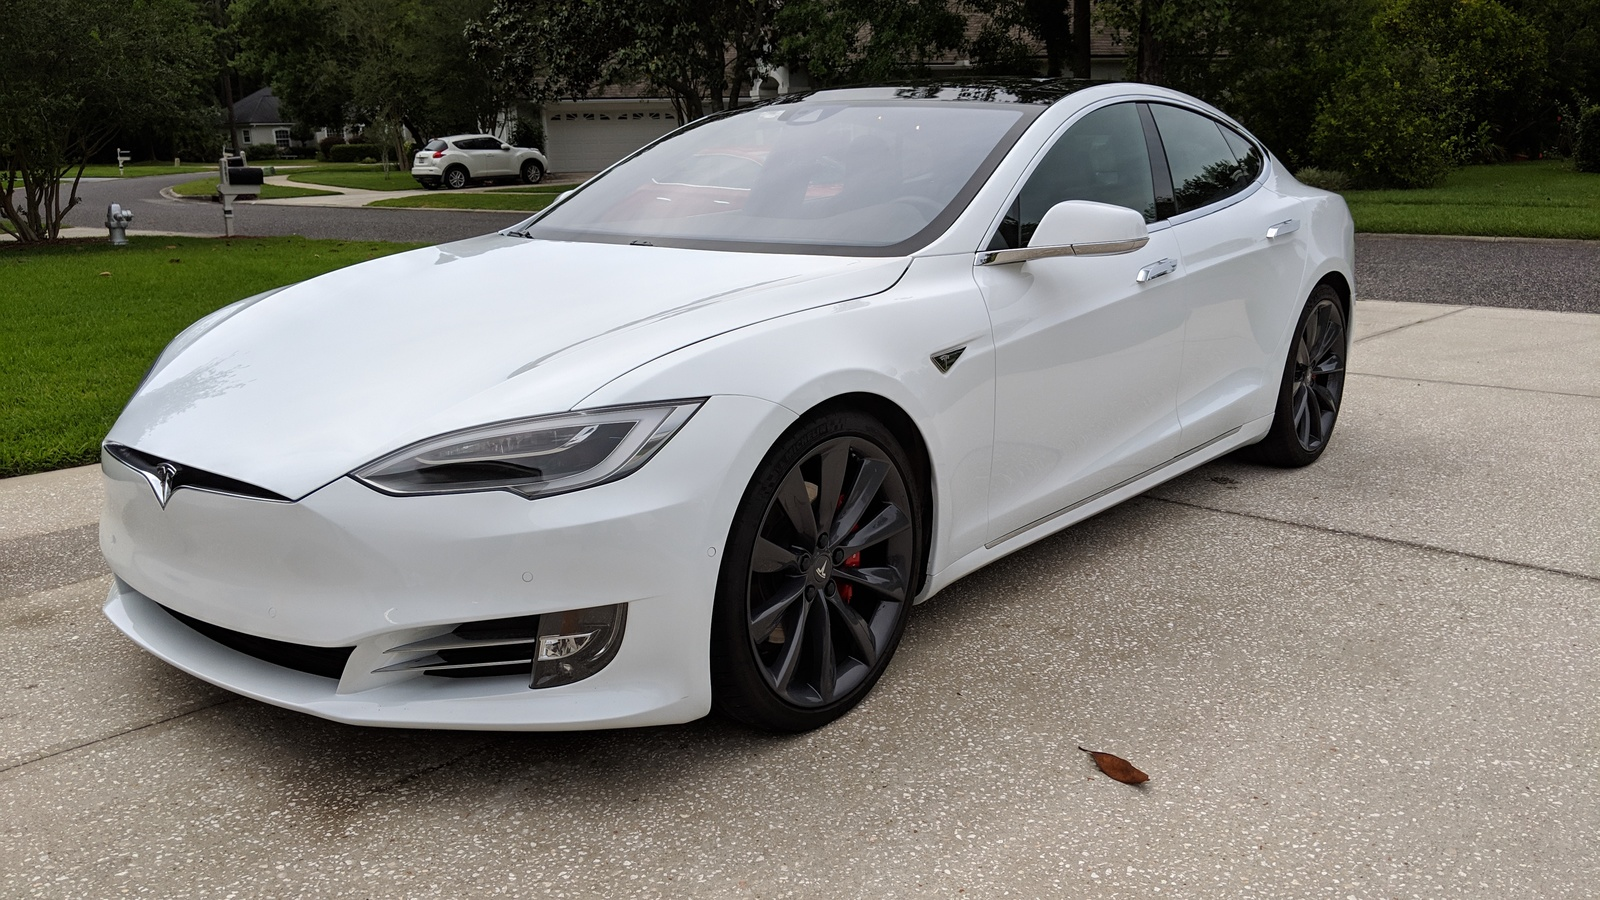

In [47]:
local_image = "car3.jpg"

Image(filename=local_image)

In [48]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [49]:
print("This image is", df.values.tolist()[0][0])

This image is a white Tesla car


In [50]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, colors)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [51]:
print("Color information:", df.values.tolist()[0][0])

Color information: white car


### Test 4

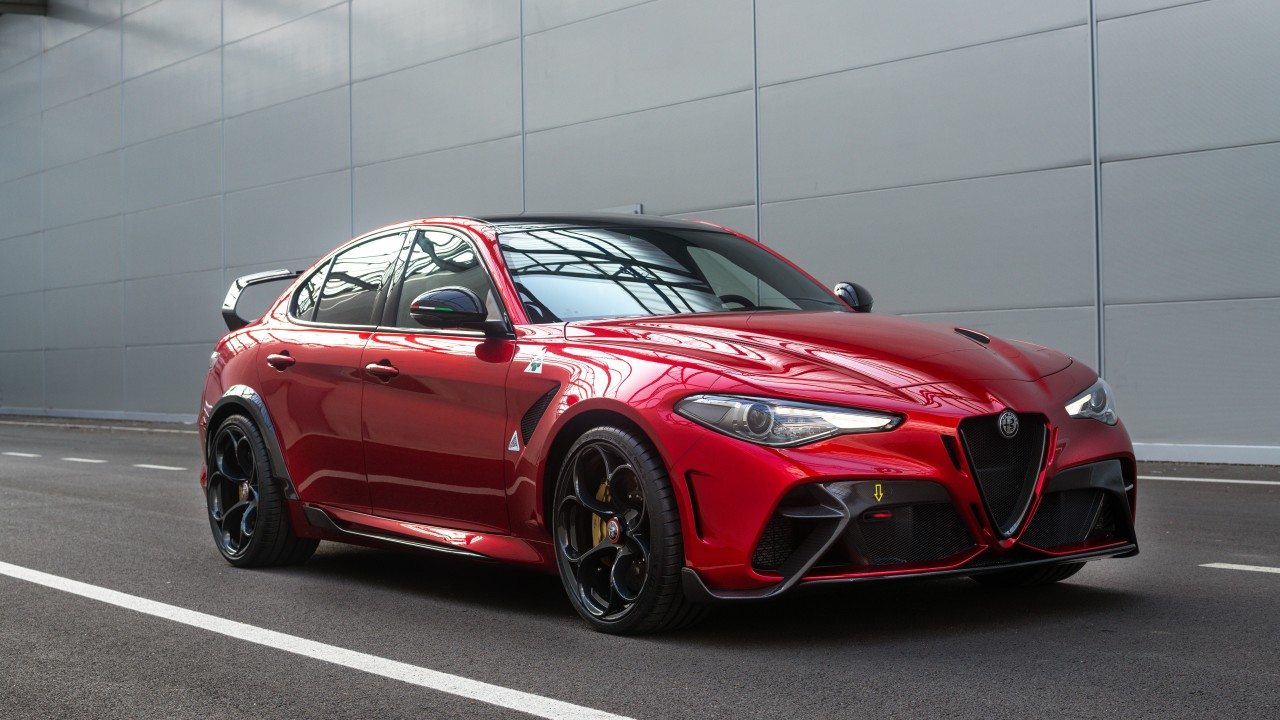

In [52]:
local_image = "car4.jpg"

Image(filename=local_image)

In [53]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [54]:
print("This image is", df.values.tolist()[0][0])

This image is an Alpha-Romeo car


In [55]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, colors)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [56]:
print("Color information:", df.values.tolist()[0][0])

Color information: red car


### Test 5

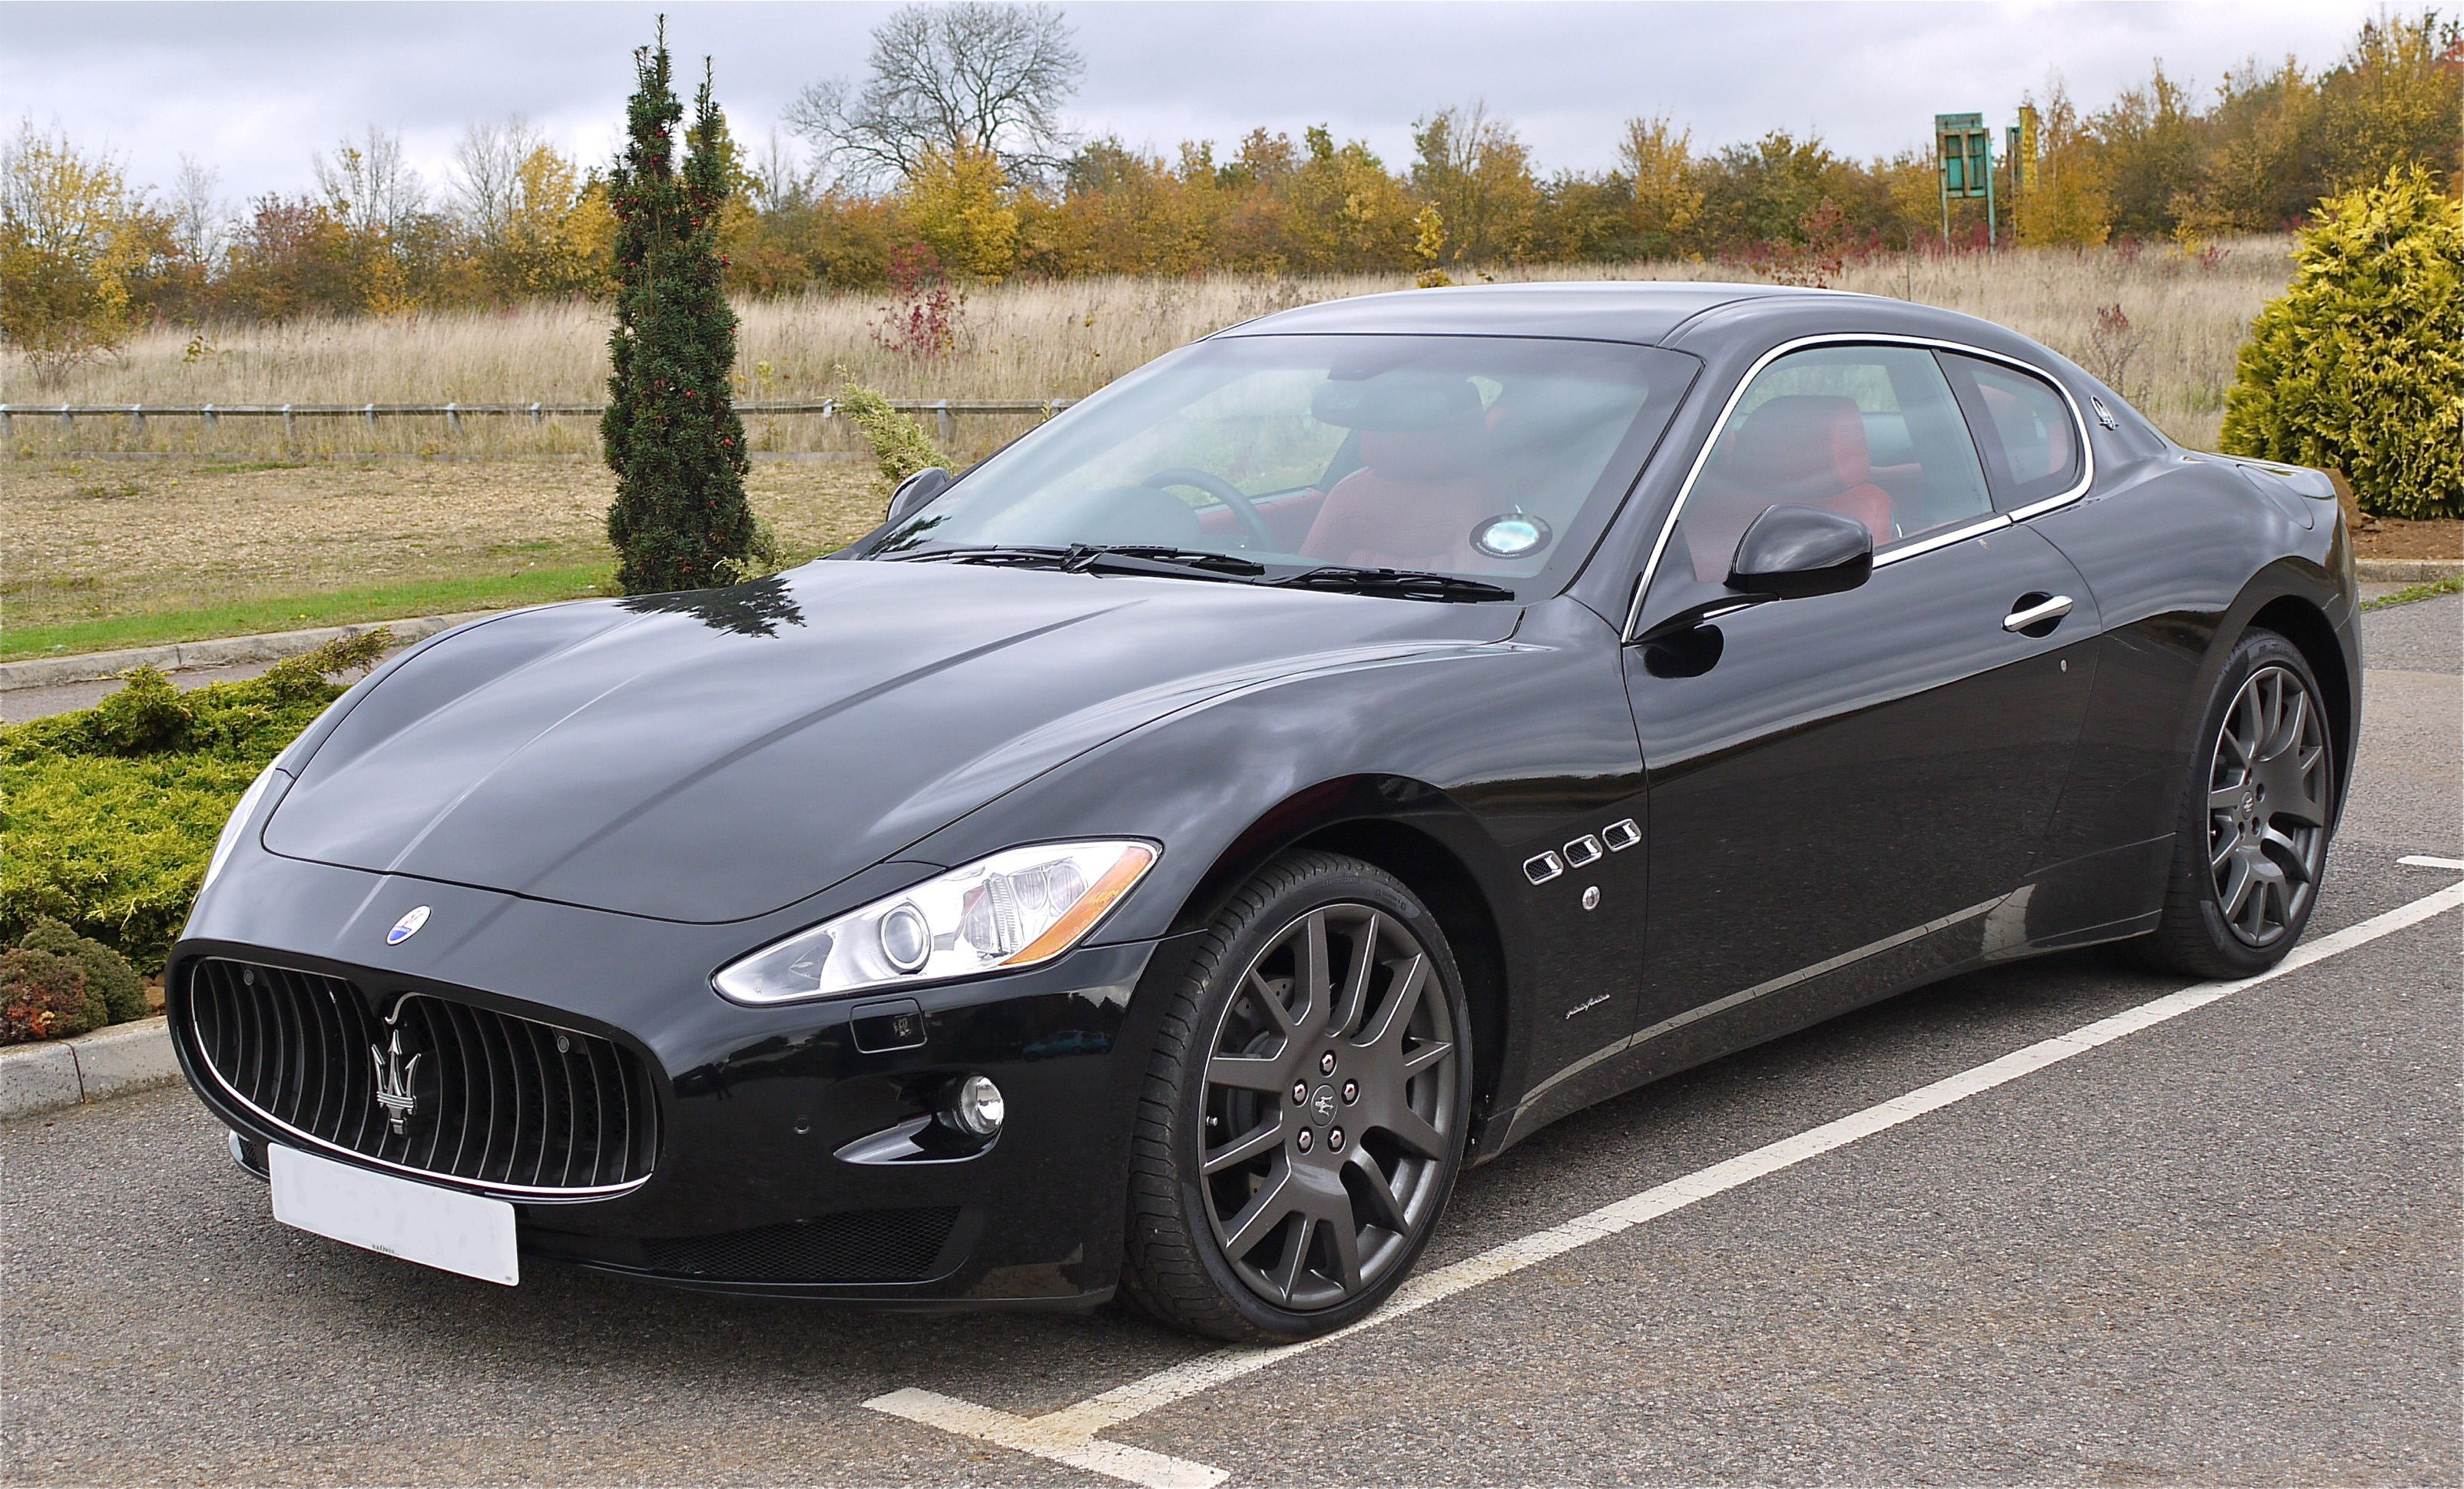

In [57]:
local_image = "car5.jpg"

Image(filename=local_image)

In [58]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [59]:
print("This image is", df.values.tolist()[0][0])

This image is a Maserati car


In [60]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, colors)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [61]:
print("Color information:", df.values.tolist()[0][0])

Color information: black car


### Test 6

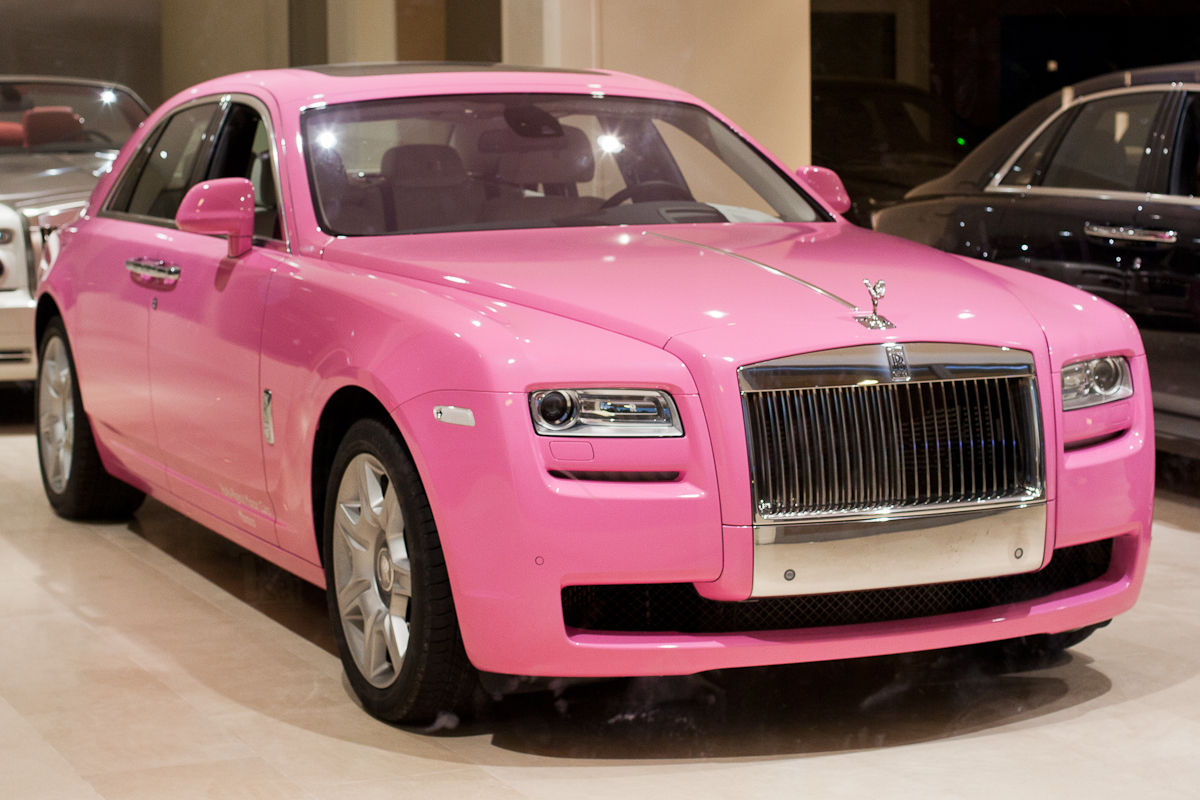

In [62]:
local_image = "car6.jpg"

Image(filename=local_image)

In [63]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [64]:
print("This image is", df.values.tolist()[0][0])

This image is a Rolls-Royce car


In [65]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, colors)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [66]:
print("Color information:", df.values.tolist()[0][0])

Color information: pink car


### Test 7

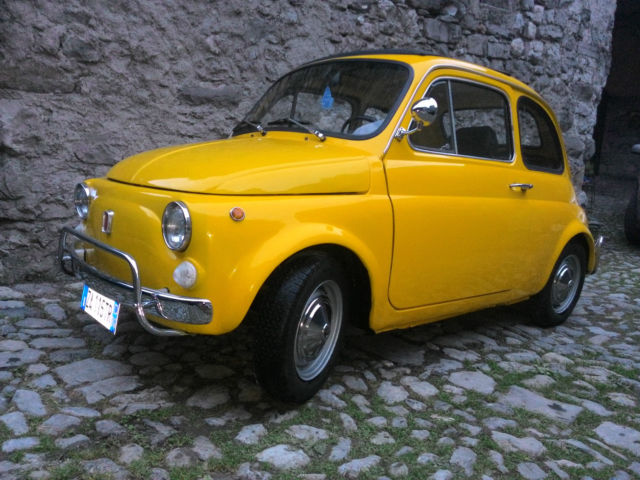

In [67]:
local_image = "car7.jpg"

Image(filename=local_image)

In [68]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, prompts)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [69]:
image_emb = image_embeddings(local_image)
df = similarity_results(image_emb, colors)
cm = sns.light_palette("purple", as_cmap=True)
df.style.background_gradient(cmap=cm)

In [70]:
print("Color information:", df.values.tolist()[0][0])

Color information: yellow car
